# Chart pattern head and shoulder 

# 1.import libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster
from scipy.signal import find_peaks

# 2️⃣ ดึงข้อมูลจาก Cassandra (30 วันล่าสุด)

In [26]:
def get_candlestick_data(symbol: str, days: int = 30):
    """ดึงข้อมูลแท่งเทียนจาก Cassandra และจัดรูปแบบ"""
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')  # keyspace ของคุณ
    except Exception as e:
        print(f"Error connecting to Cassandra: {e}")
        raise ConnectionRefusedError("Could not connect to Cassandra. Check if it's running.")

    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol = '{symbol}'
        ORDER BY time DESC
        LIMIT {days}
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError(f"No data found for {symbol}")

    df = df.sort_values('time')  # เรียงจากเก่า → ใหม่
    df.columns = df.columns.str.strip().str.lower()  # ล้างชื่อคอลัมน์
    df.rename(columns={
        'open_price': 'open',
        'high_price': 'high',
        'low_price': 'low',
        'close_price': 'close'
    }, inplace=True)

    df.set_index('time', inplace=True)
    
    # ตรวจสอบและแปลง Type ให้เป็น float
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df



# 3️⃣ ฟังก์ชันตรวจจับ H&S (ปรับปรุงการคำนวณ Neckline/Target)

In [27]:
def detect_head_shoulders(df, distance=5, tolerance=0.03, debug=False):
    """ตรวจจับ H&S/IH&S พร้อมคำนวณ Target Price และ Breakout"""
    prices = df['close'].values
    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    patterns = []

    # Head & Shoulders (H&S)
    for i in range(2, len(peaks)):
        l, h, r = peaks[i-2], peaks[i-1], peaks[i]
        if r >= len(prices) - 1: continue 
            
        left, head, right = prices[l], prices[h], prices[r]
        
        if head > left and head > right and abs(left - right) / head < tolerance:
            
            # ฐาน Neckline (Trough 1 และ Trough 2)
            trough1_idx = np.argmin(prices[l:h]) + l
            trough2_idx = np.argmin(prices[h:r]) + h
            neck_start_price = prices[trough1_idx]
            neck_end_price = prices[trough2_idx]
            neck_slope = (neck_end_price - neck_start_price) / (trough2_idx - trough1_idx)
            
            # หาจุด Breakout (ใช้ Trough 2 เป็นจุดเริ่ม)
            post_pattern = prices[trough2_idx:]
            t_diff = np.arange(len(post_pattern))
            neckline_series = neck_end_price + neck_slope * t_diff

            breakout_points = np.where(post_pattern < neckline_series)[0]
            
            if len(breakout_points) > 0:
                break_idx = trough2_idx + breakout_points[0]
                break_price = prices[break_idx]

                # Target Calculation (ใช้ความสูงจาก Head ถึง Neckline)
                # คำนวณราคา Neckline ที่ตรงกับจุด Head (h)
                neckline_at_head = neck_start_price + neck_slope * (h - trough1_idx)
                target_height = head - neckline_at_head 
                
                # Target Price = Breakout Price - Target Height
                target_price = break_price - target_height
                
                patterns.append({
                    "type": "H&S",
                    "l_idx": l, "h_idx": h, "r_idx": r,
                    "t1_idx": trough1_idx, "t2_idx": trough2_idx,
                    "neck_slope": neck_slope,
                    "break_idx": break_idx,
                    "break_price": break_price,
                    "target_price": target_price
                })
                if debug:
                    print(f"Found H&S at index {h}, Target: {target_price:.2f}")

    # Inverse Head & Shoulders (IH&S)
    for i in range(2, len(troughs)):
        l, h, r = troughs[i-2], troughs[i-1], troughs[i]
        if r >= len(prices) - 1: continue

        left, head, right = prices[l], prices[h], prices[r]
        
        if head < left and head < right and abs(left - right) / head < tolerance:
            
            # ฐาน Neckline (Peak 1 และ Peak 2)
            peak1_idx = np.argmax(prices[l:h]) + l
            peak2_idx = np.argmax(prices[h:r]) + h
            neck_start_price = prices[peak1_idx]
            neck_end_price = prices[peak2_idx]
            neck_slope = (neck_end_price - neck_start_price) / (peak2_idx - peak1_idx)

            # หาจุด Breakout (เริ่มจาก Peak 2)
            post_pattern = prices[peak2_idx:]
            t_diff = np.arange(len(post_pattern))
            neckline_series = neck_end_price + neck_slope * t_diff
            
            breakout_points = np.where(post_pattern > neckline_series)[0]
            
            if len(breakout_points) > 0:
                break_idx = peak2_idx + breakout_points[0]
                break_price = prices[break_idx]
                
                # Target Calculation
                # คำนวณราคา Neckline ที่ตรงกับจุด Head (h)
                neckline_at_head = neck_start_price + neck_slope * (h - peak1_idx)
                target_height = neckline_at_head - head
                
                # Target Price = Breakout Price + Target Height
                target_price = break_price + target_height

                patterns.append({
                    "type": "IH&S",
                    "l_idx": l, "h_idx": h, "r_idx": r,
                    "t1_idx": peak1_idx, "t2_idx": peak2_idx,
                    "neck_slope": neck_slope,
                    "break_idx": break_idx,
                    "break_price": break_price,
                    "target_price": target_price
                })
                if debug:
                    print(f"Found IH&S at index {h}, Target: {target_price:.2f}")

    return patterns


# 4️⃣ ส่วน Main Execution

Found H&S at index 12, Target: 36.35
Found IH&S at index 26, Target: 42.22
Found IH&S at index 42, Target: 41.60

Found 3 patterns for AOT


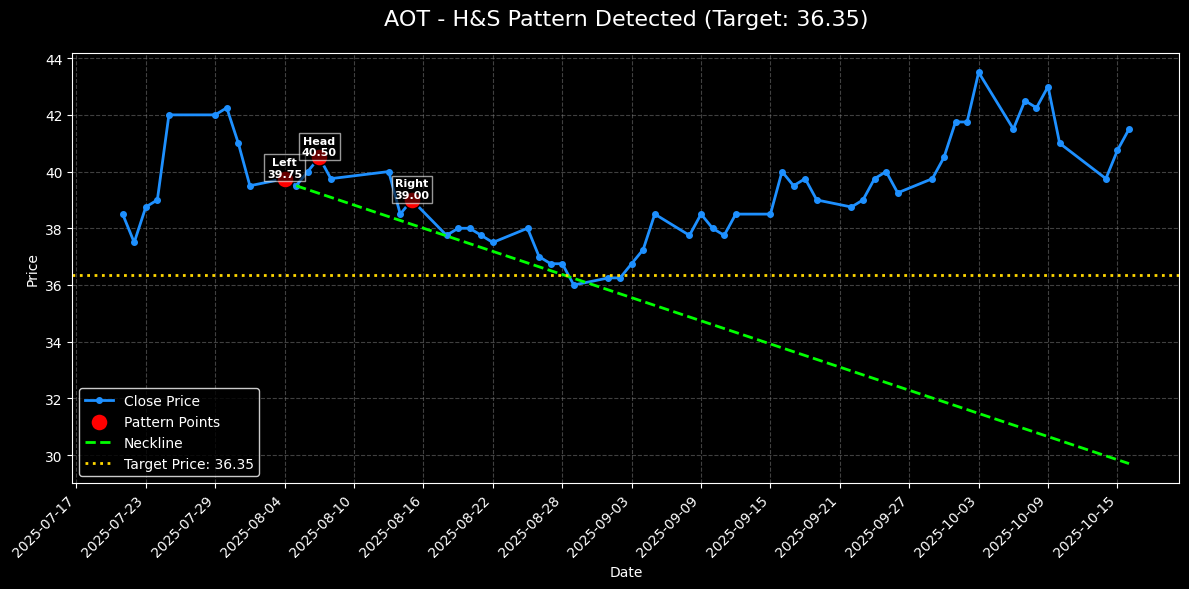

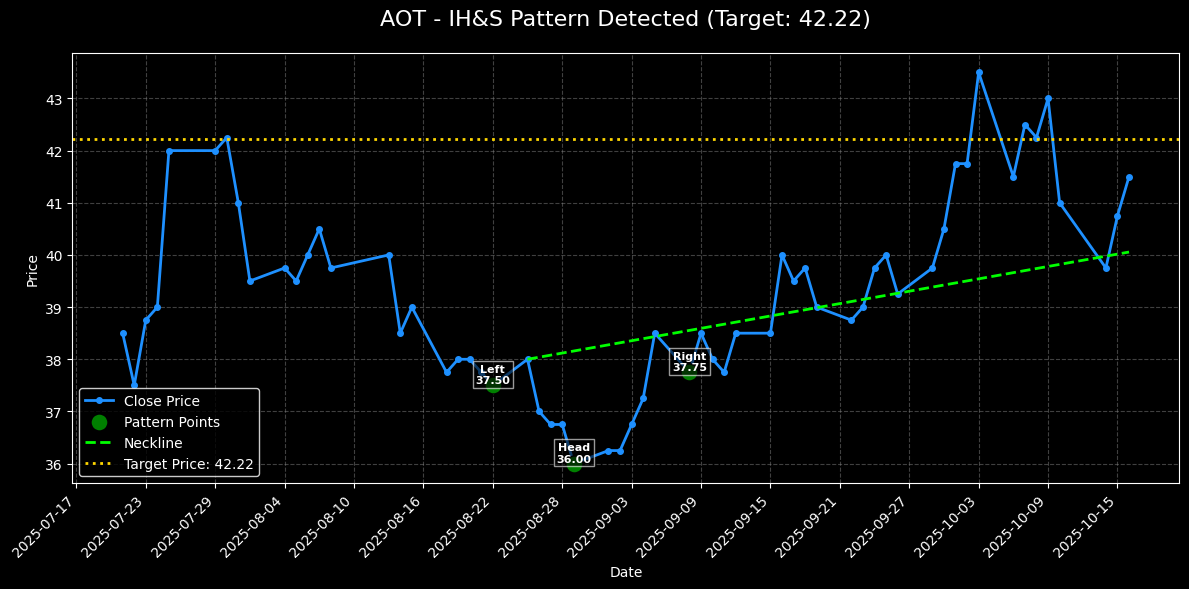

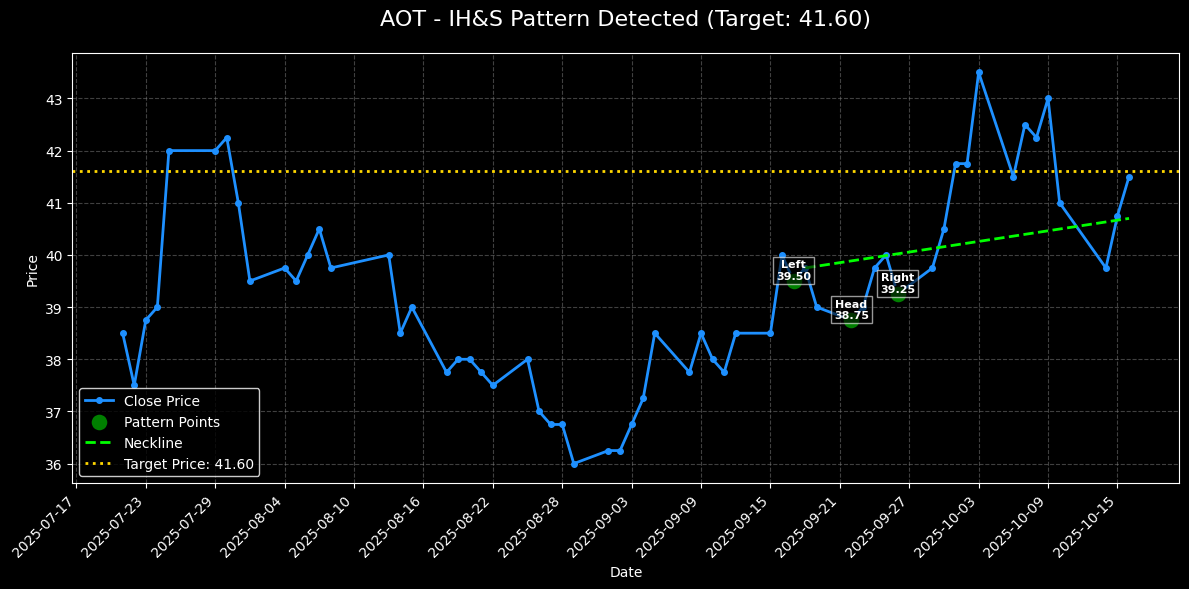

In [29]:
if __name__ == '__main__':
    try:
        symbol = "AOT"
        df = get_candlestick_data(symbol, days=60)
        patterns = detect_head_shoulders(df, distance=3, tolerance=0.05, debug=True)

        print(f"\nFound {len(patterns)} patterns for {symbol}")

        # แสดงกราฟทีละ Pattern
        for p in patterns:
            plt.style.use('dark_background')
            plt.figure(figsize=(12,6))
            
            # 1. วาดเส้นราคา (Close Price)
            plt.plot(df.index, df['close'], 
                     color='dodgerblue', 
                     linewidth=2, 
                     marker='.', 
                     markersize=8, 
                     label='Close Price')
            
            # 2. จุด H&S หรือ IH&S (Pattern Points)
            points_idx = [p['l_idx'], p['h_idx'], p['r_idx']]
            points_price = df['close'].iloc[points_idx].values
            pattern_color = 'red' if p['type'] == 'H&S' else 'green'
            plt.scatter(df.index[points_idx], points_price,
                        color=pattern_color, s=150, edgecolors='black', zorder=5, label='Pattern Points')
            
            # แสดงตัวเลขราคาที่แต่ละจุด
            labels = ['Left', 'Head', 'Right']
            for i, idx in enumerate(points_idx):
                plt.text(df.index[idx], points_price[i], f"{labels[i]}\n{points_price[i]:.2f}",
                         color='white', fontsize=8, fontweight='bold',
                         ha='center', va='bottom', zorder=6, bbox=dict(facecolor='black', alpha=0.6, pad=2))
            
            # 3. วาดเส้น Neckline (ลากจาก T1/P1 ไป T2/P2 และยืดออกไปจนสุดกราฟ)
            t1_idx = p['t1_idx']
            t2_idx = p['t2_idx']
            neck_start_price = df['close'].iloc[t1_idx]
            
            # คำนวณราคา Neckline ที่จุดสุดท้ายของกราฟ
            final_neck_price = neck_start_price + p['neck_slope'] * (len(df.index) - 1 - t1_idx)
            
            plt.plot([df.index[t1_idx], df.index[-1]],
                     [neck_start_price, final_neck_price],
                     color='lime', linewidth=2, linestyle='--', label='Neckline')

            # 4. วาดเส้น Target Price (เส้นแนวนอน)
            target_price = p['target_price']
            plt.axhline(target_price, color='gold', linestyle=':', linewidth=2, label=f"Target Price: {target_price:.2f}")

            # 🚨 นำส่วน Breakout Point และ Price Target Forecast Line ออกแล้ว
            
            # ปรับแต่งกราฟ
            plt.title(f"{symbol} - {p['type']} Pattern Detected (Target: {target_price:.2f})", fontsize=16, color='white', pad=20)
            plt.xlabel('Date', color='white')
            plt.ylabel('Price', color='white')
            
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(df)//10)))
            plt.xticks(rotation=45, ha='right')
            
            plt.gca().tick_params(axis='x', colors='white')
            plt.gca().tick_params(axis='y', colors='white')
            
            plt.grid(True, color='gray', linestyle='--', alpha=0.5)
            plt.legend(facecolor='black', edgecolor='white')
            plt.tight_layout()
            plt.show()
            
    except ConnectionRefusedError as e:
        print(f"\n❌ การเชื่อมต่อล้มเหลว: {e}")
        print("โปรดตรวจสอบว่า Cassandra Server (127.0.0.1:9042) ได้รันอยู่หรือไม่")
    except ValueError as e:
        print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
    except Exception as e:
        print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")